In [1]:
import vnstock as vns
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from MFI import mfi
from RSI import rsi


In [2]:
ticker = 'FPT'

In [3]:
df = vns.stock_historical_data(symbol = ticker, start_date="2014-01-01", 
                            end_date='2024-06-01', resolution='1D', type='stock')


In [4]:

def calculate_indicators(data, ticker):
    data['mfi'] = mfi(data)

    data = data[['time', 'close', 'mfi']]
    data.set_index('time', inplace = True)
    data.columns = [ticker, 'mfi']
    data = data.dropna()

    data['sma10'] = data[ticker].rolling(window = 10, min_periods = 1).mean()
    
    data['sma50'] = data[ticker].rolling(window = 50, min_periods = 1).mean()
    
    data['ema'] = data[ticker].ewm(span = 10).mean()
    
    data['rsi'] = rsi(data, ticker)

    return data.dropna()


In [5]:
df = calculate_indicators(df, ticker)

In [6]:
df

,FPT,mfi,sma10,sma50,ema,rsi
time,,,,,,
2014-01-15,7060,92.937360,6827.0,6827.000000,6892.231990,84.905660
2014-01-16,7130,94.040055,6871.0,6854.545455,6940.805022,86.666667
2014-01-17,7270,95.064683,6930.0,6889.166667,7006.577576,90.410959
2014-01-20,7340,95.630284,6986.0,6923.846154,7072.018146,90.000000
2014-01-21,7490,95.969992,7064.0,6964.285714,7152.886497,100.000000
...,...,...,...,...,...,...
2024-05-27,114690,41.084470,116045.0,104621.000000,115261.585431,57.710012
2024-05-28,118320,42.923023,116607.0,104966.600000,115817.660807,63.828740
2024-05-29,117190,46.534471,116745.0,105289.600000,116067.177024,53.762268


In [7]:
length_data = len(df)    
length_train = round(length_data * 0.6)  
length_validation = round(length_data * 0.2)  
length_test = length_data - length_train - length_validation

#Validation set is for tuning parameters and test set is for actual testing

In [8]:
train_data = df[:length_train]
validation_data = df[length_train:length_train+length_validation]
test_data = df[length_train+length_validation:]

In [9]:
# train_data = train_data.to_frame()
# validation_data = validation_data.to_frame()
# test_data = test_data.to_frame()

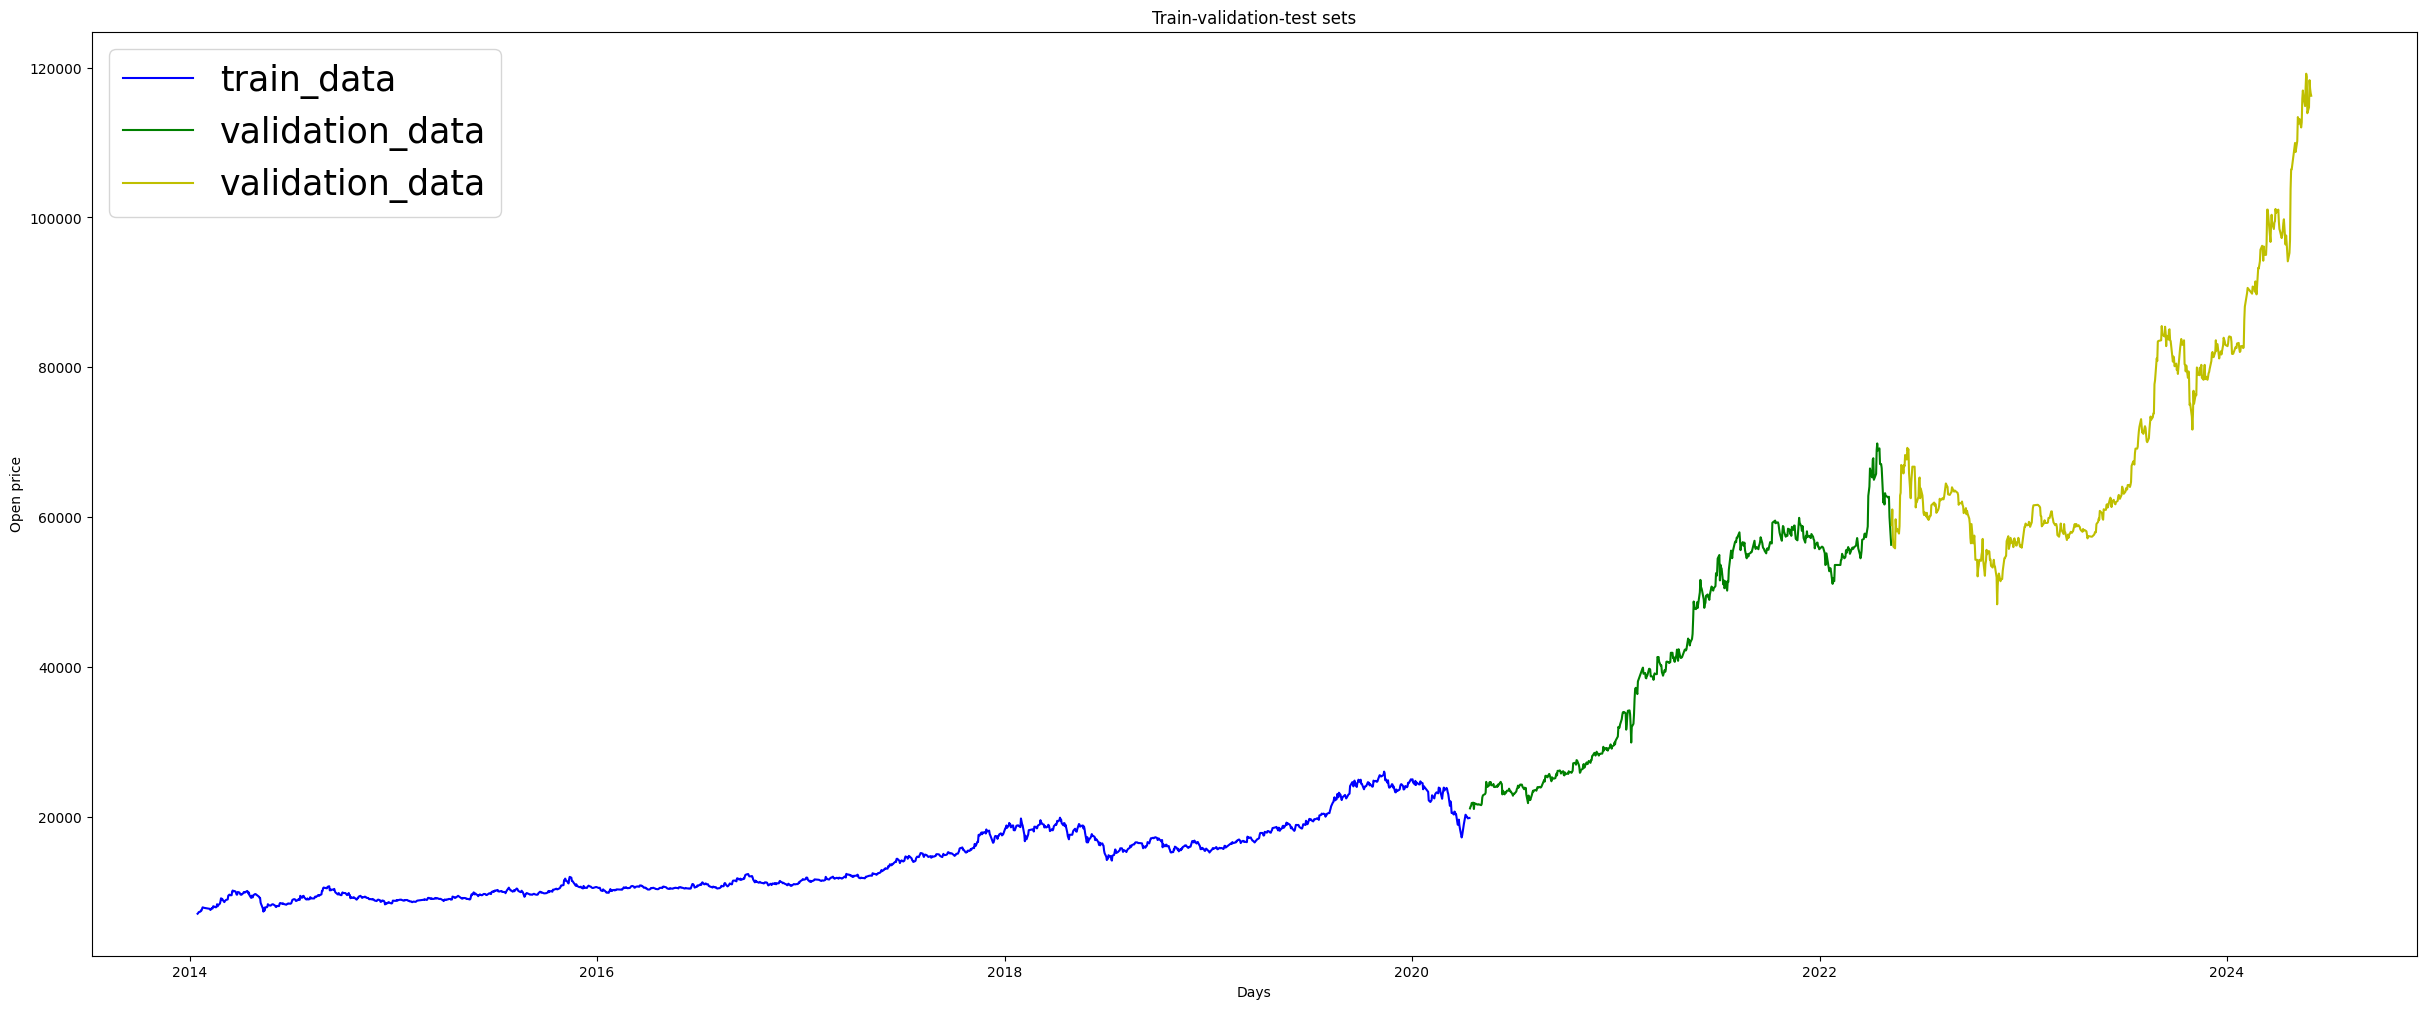

In [10]:
indicator = ticker

plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data[indicator], label = "train_data", color = "b")
plt.plot(validation_data.index, validation_data[indicator], label = "validation_data", color = "g")
plt.plot(test_data.index, test_data[indicator], label = "validation_data", color = "y")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Train-validation-test sets")
plt.legend(fontsize = 25)
plt.show()

In [11]:
df_train = train_data.values
df_train = np.reshape(df_train, (-1,df_train.shape[1],1))

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

df_train_scaled = scaler.fit_transform(df_train.reshape(-1, 1)).reshape(df_train.shape)

X_train = []
y_train = []

time_step = 5

for i in range(time_step, length_train-time_step):
    X_train.append(df_train_scaled[i-time_step:i])
    y_train.append(df_train_scaled[i:i+time_step])
    
X_train, y_train = np.array(X_train), np.array(y_train)


In [12]:
y_train.shape

(1542, 5, 6, 1)

In [13]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dropout

# keras.utils.set_random_seed(622)

unit_num = 256
hidden_layers = 1
# initializing the RNN
regressor = Sequential()

regressor.add(
    LSTM(units = unit_num,
         activation = "tanh",
         input_shape = (X_train.shape[1], X_train.shape[2]))
             )

regressor.add(
    Dropout(0.2)
             )

# regressor.add(Dense(units = 25))

# adding the output layer
regressor.add(Dense(units = X_train.shape[3]))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_absolute_error",
    metrics = ["mean_absolute_error"])


c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 30, batch_size = 32)

Epoch 1/30


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/compile_loss/mean_absolute_error/sub/BroadcastGradientArgs defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1987, in _run_once

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "C:\Users\huyvu\AppData\Roaming\Python\Python312\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\huyvu\AppData\Local\Temp\ipykernel_19516\2078774034.py", line 2, in <module>

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 117, in one_step_on_iterator

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 104, in one_step_on_data

  File "c:\Users\huyvu\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 66, in train_step

Incompatible shapes: [32,5,6,1] vs. [32,1]
	 [[{{node gradient_tape/compile_loss/mean_absolute_error/sub/BroadcastGradientArgs}}]] [Op:__inference_one_step_on_iterator_2236]

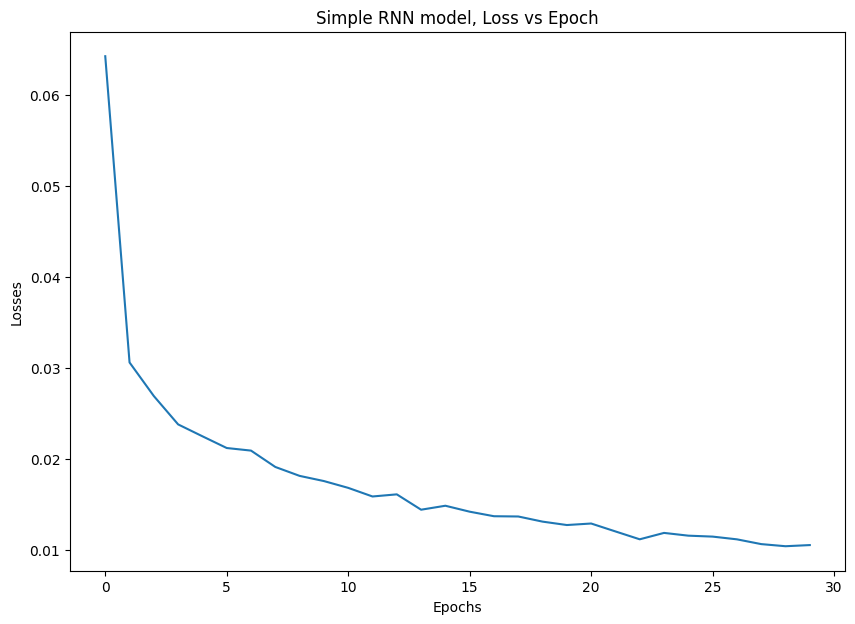

In [ ]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [ ]:
y_train_pred = regressor.predict(X_train)  
y_train_pred = scaler.inverse_transform(y_train_pred)
y_train_pred = pd.DataFrame(y_train_pred, columns = df.columns)

y_train = scaler.inverse_transform(y_train.reshape(-1,1)).reshape(y_train.shape) 
y_train = pd.DataFrame(y_train.reshape(-1,6), columns = df.columns)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


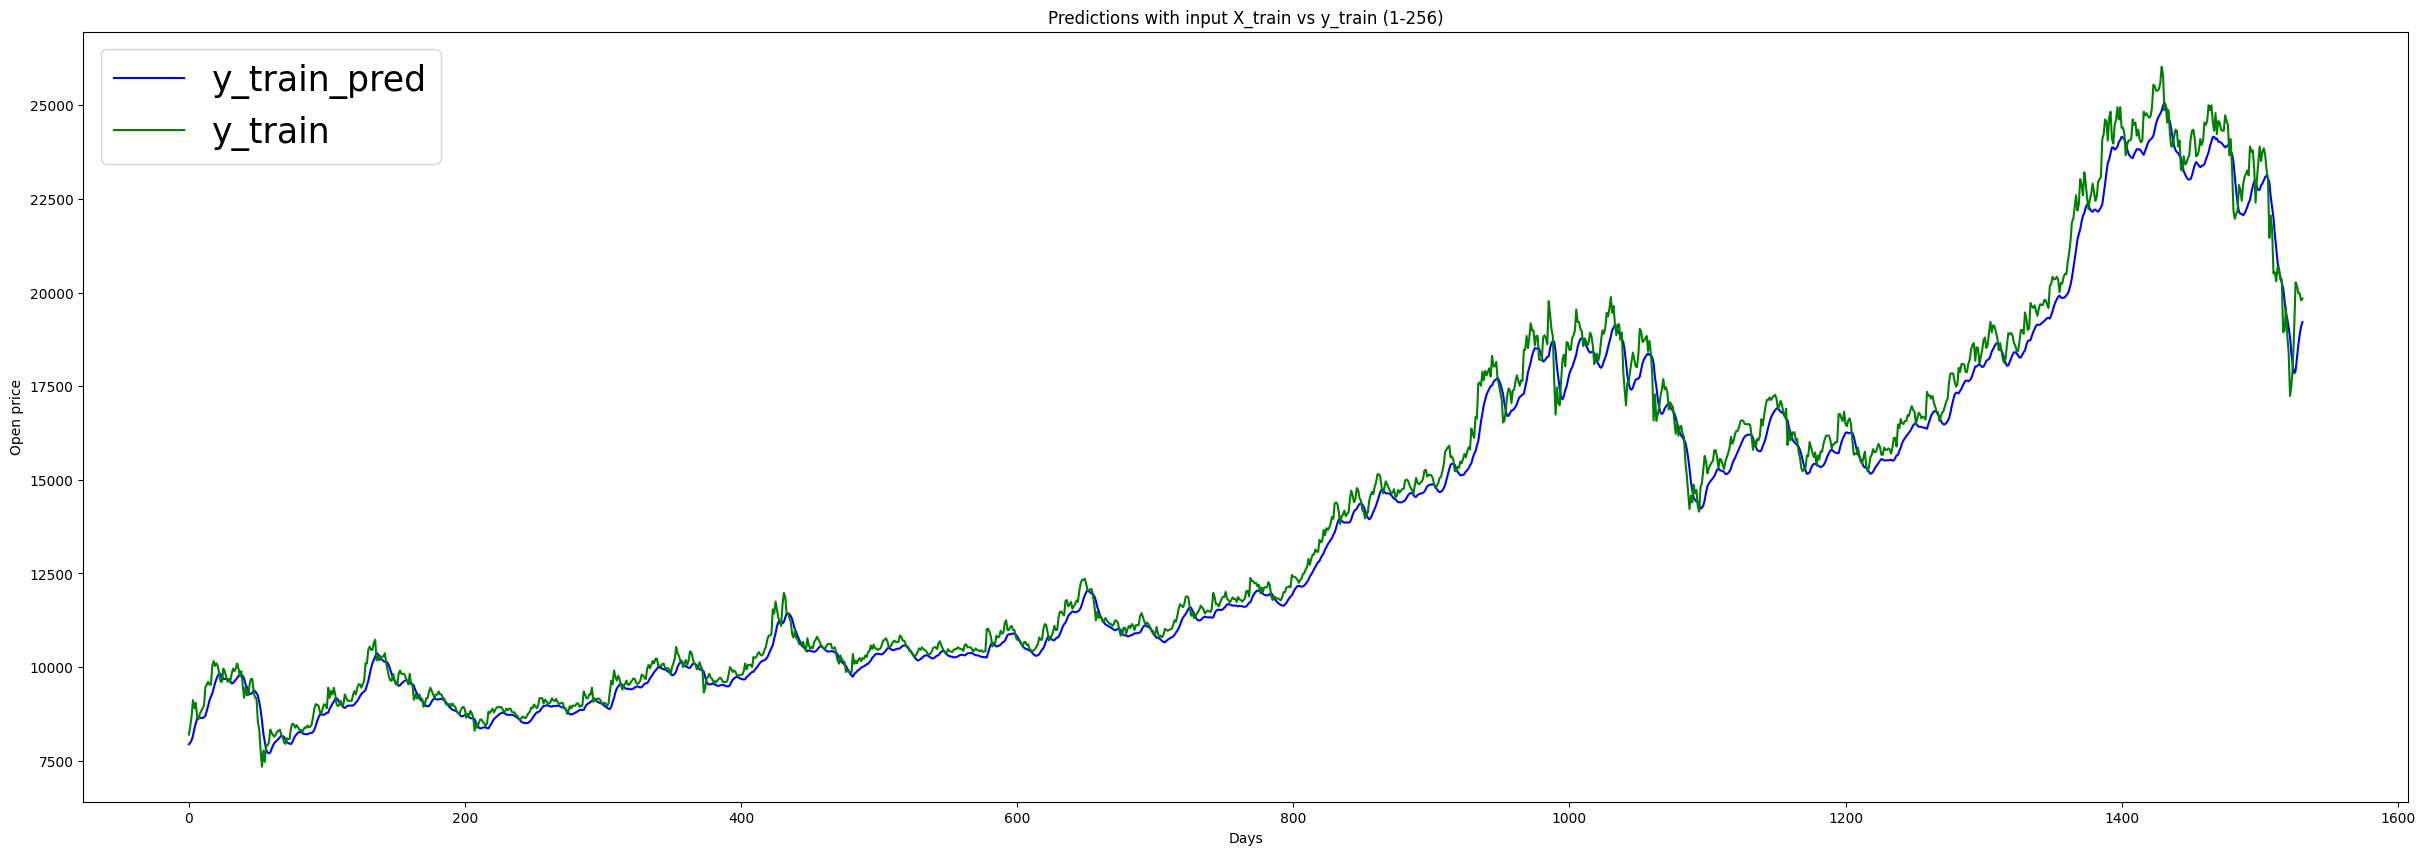

In [ ]:
indicator = ticker
plt.figure(figsize = (30,10))
plt.plot(y_train_pred[indicator], color = "b", label = "y_train_pred" )
plt.plot(y_train[indicator], color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title(f"Predictions with input X_train vs y_train ({hidden_layers}-{unit_num})")
plt.legend(fontsize = 25)
plt.show()

In [ ]:
df_validation = validation_data.values 
df_validation = np.reshape(df_validation, (-1,df_validation.shape[1], 1)) 

scaled_df_validation =  scaler.transform(df_validation.reshape(-1 ,1)).reshape(df_validation.shape)  

X_validation = []
y_validation = []

for i in range(time_step, length_validation-time_step):
    X_validation.append(scaled_df_validation[i-time_step:i])
    y_validation.append(scaled_df_validation[i:i+time_step])

X_validation, y_validation = np.array(X_validation), np.array(y_validation)

In [ ]:
y_validation_pred = regressor.predict(X_validation)

y_validation_pred = scaler.inverse_transform(y_validation_pred) 
y_validation_pred = pd.DataFrame(y_validation_pred, columns = df.columns)

y_validation = scaler.inverse_transform(y_validation.reshape(-1,1)).reshape(y_validation.shape) 
y_validation = pd.DataFrame(y_validation.reshape(-1,6), columns = df.columns)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


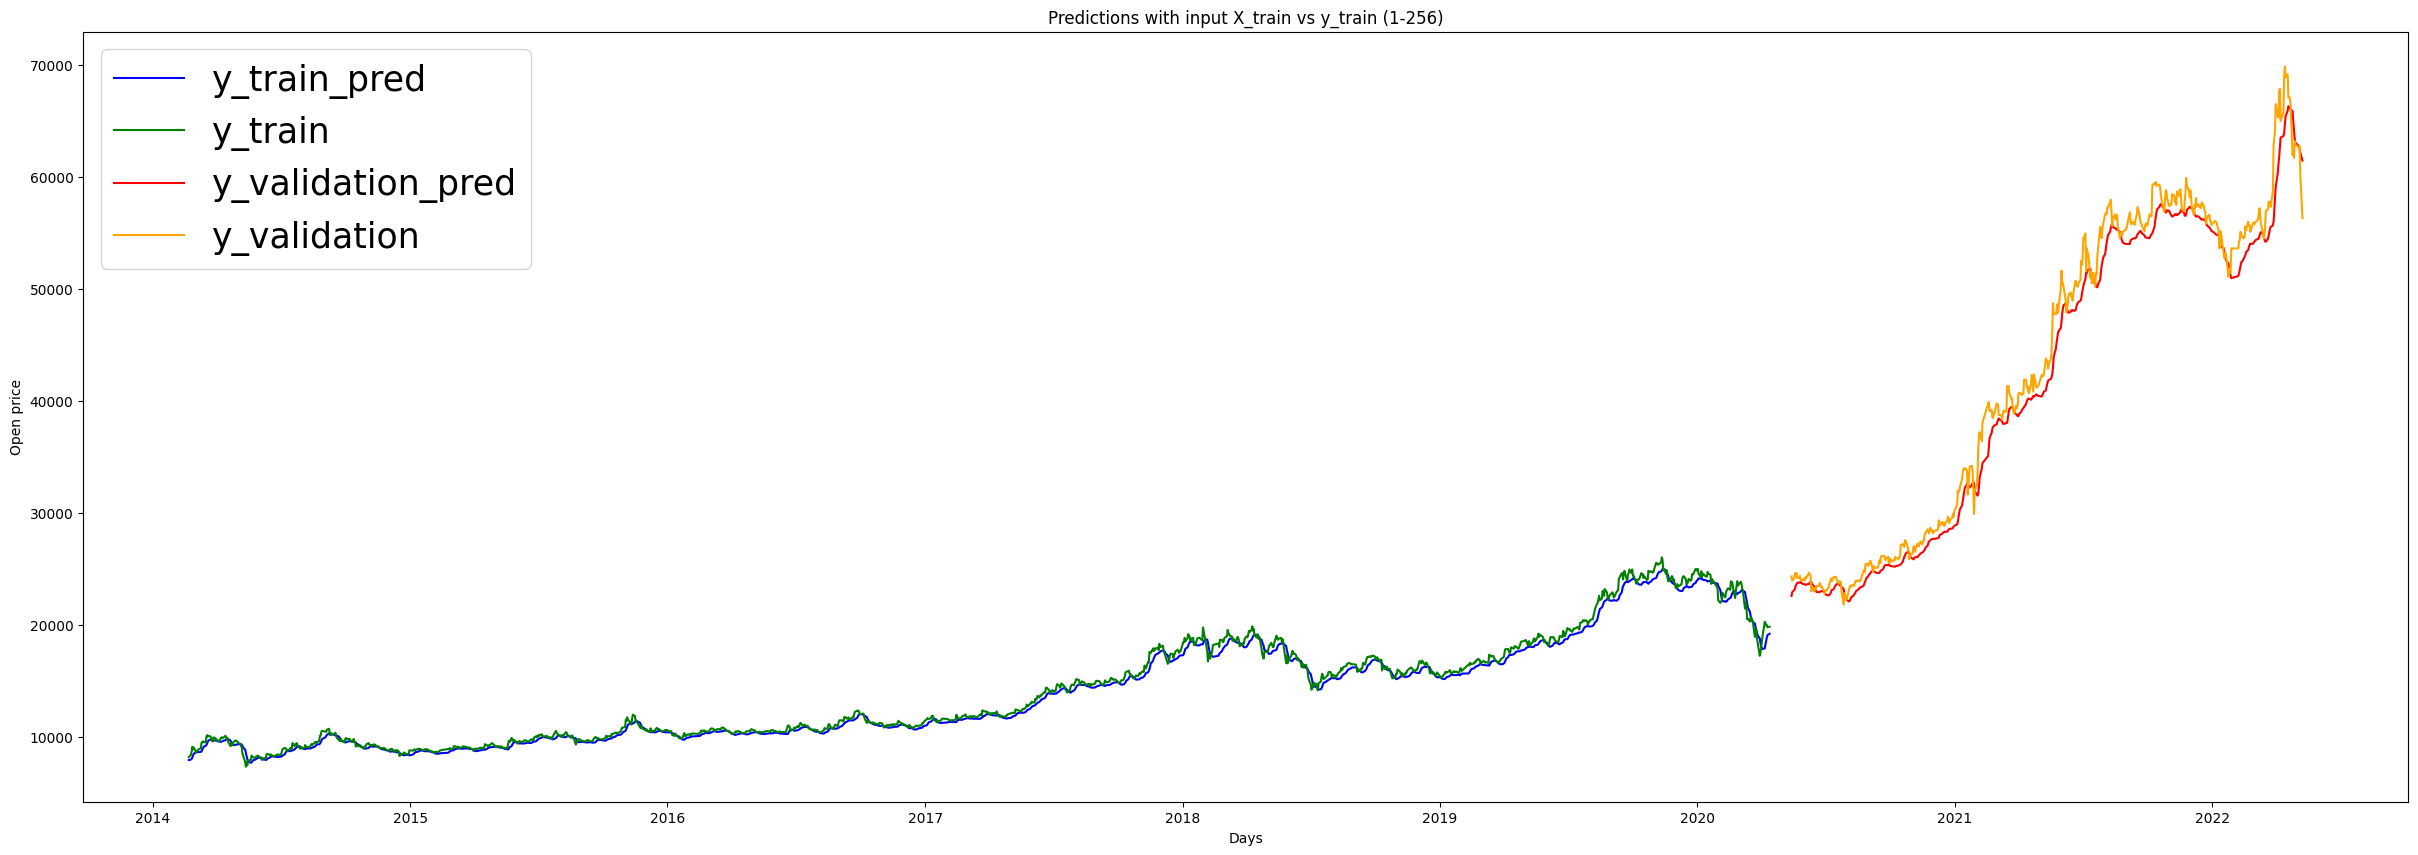

In [ ]:
indicator = ticker
plt.figure(figsize = (30,10))
plt.plot(train_data.index[time_step:], y_train_pred[indicator], color = "b", label = "y_train_pred" )
plt.plot(train_data.index[time_step:], y_train[indicator], color = "g", label = "y_train")
plt.plot(validation_data.index[time_step:], y_validation_pred[indicator], color = "r", label = "y_validation_pred" )
plt.plot(validation_data.index[time_step:], y_validation[indicator], color = "orange", label = "y_validation")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title(f"Predictions with input X_train vs y_train ({hidden_layers}-{unit_num})")
plt.legend(fontsize = 25)
plt.show()



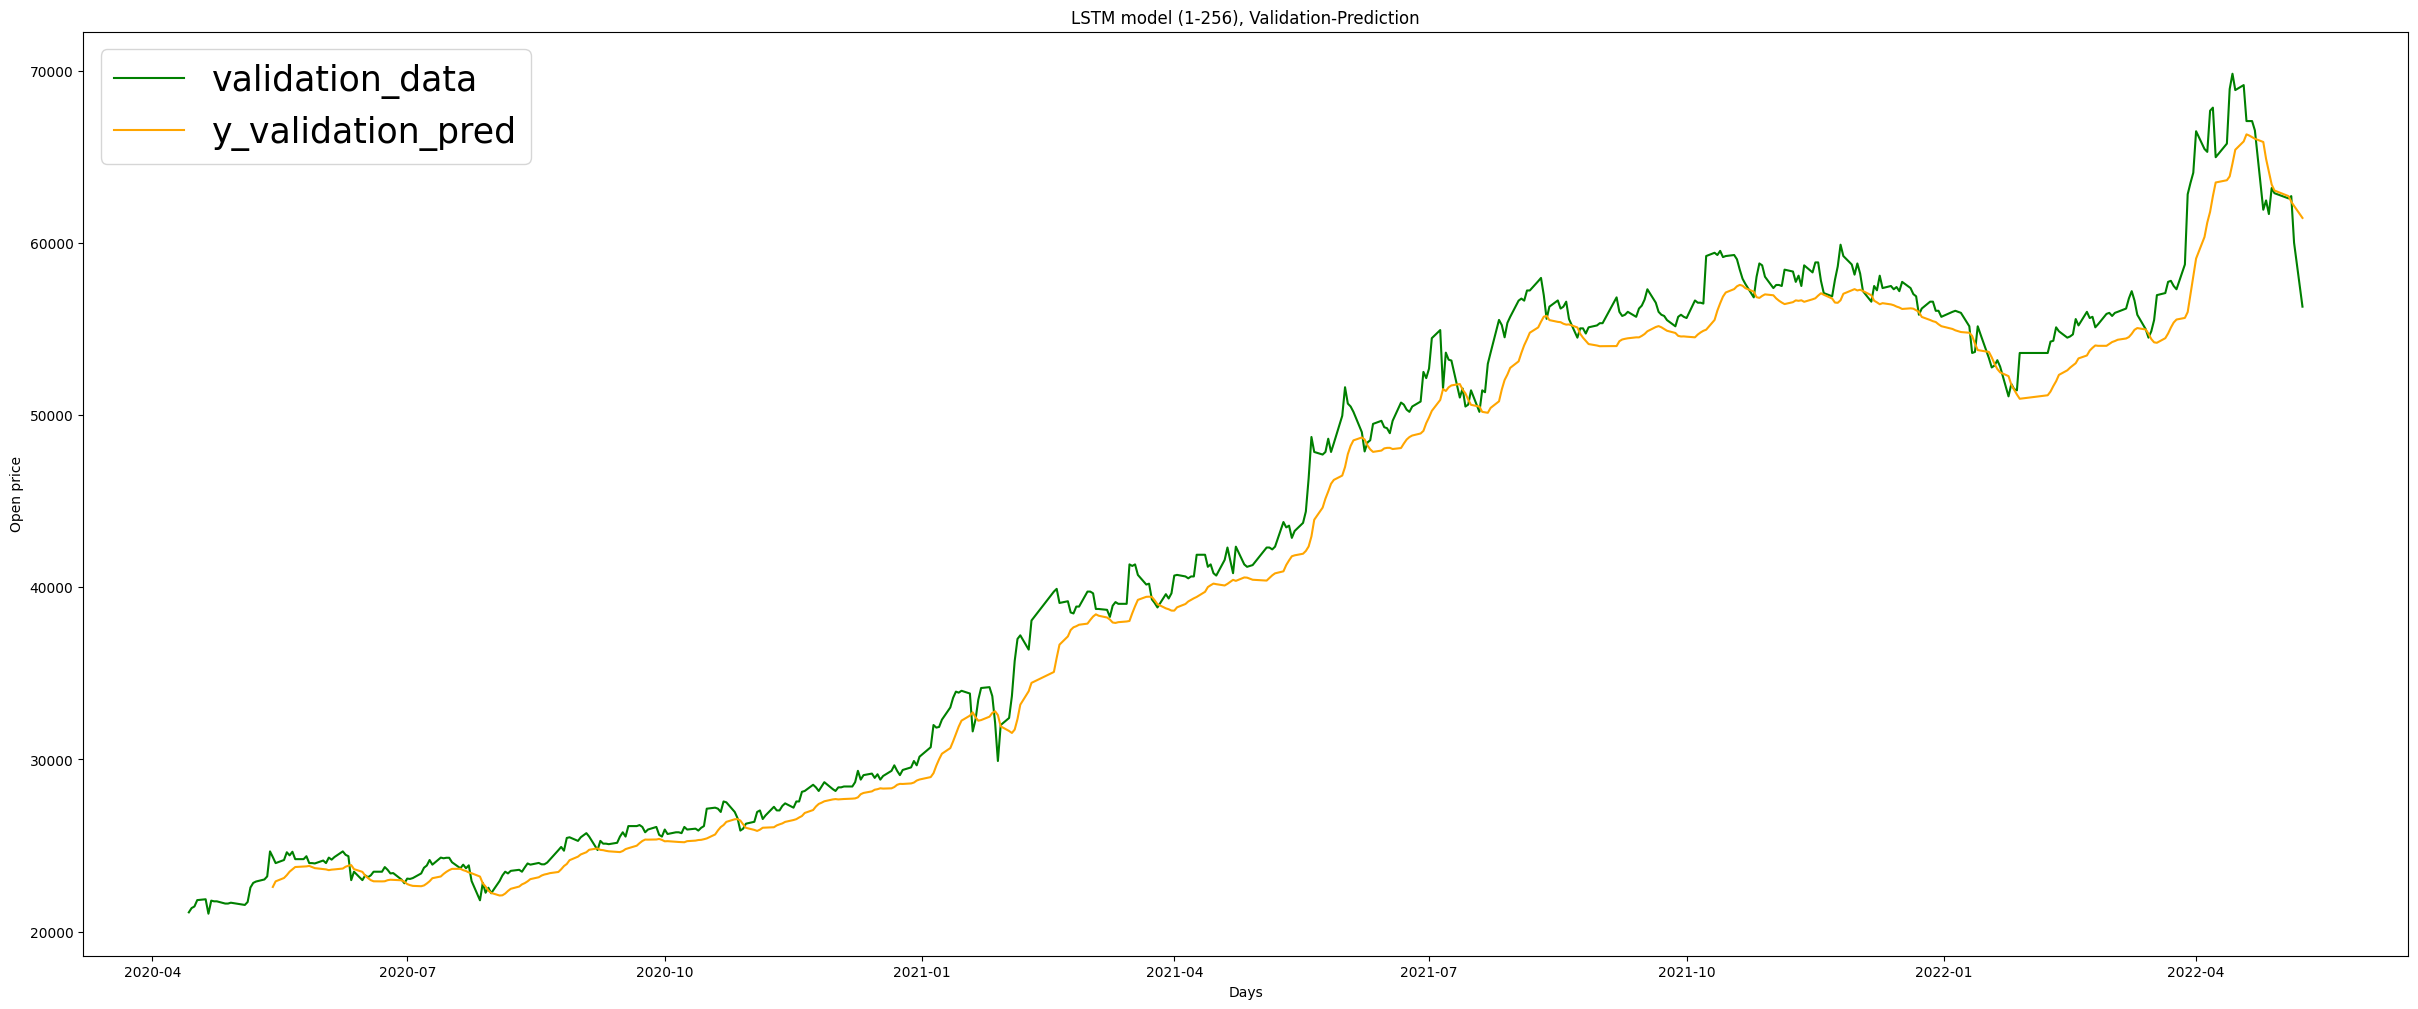

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(validation_data.index, validation_data[ticker], label = "validation_data", color = "g")
plt.plot(validation_data.index[time_step:], y_validation_pred[indicator], label = "y_validation_pred", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title(f"LSTM model ({hidden_layers}-{unit_num}), Validation-Prediction")
plt.legend(fontsize = 25)
plt.show()

In [ ]:
df_test = test_data.values 
df_test = np.reshape(df_test, (-1,df_test.shape[1], 1)) 

scaled_df_test =  scaler.transform(df_test.reshape(-1 ,1)).reshape(df_test.shape)  

X_test = []
y_test = []

for i in range(time_step, length_test-time_step):
    X_test.append(scaled_df_test[i-time_step:i])
    y_test.append(scaled_df_test[i:i+time_step])

X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
y_test_pred = regressor.predict(X_test)

y_test_pred = scaler.inverse_transform(y_test_pred) 
y_test_pred = pd.DataFrame(y_test_pred, columns = df.columns)

y_test = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape) 
y_test = pd.DataFrame(y_test.reshape(-1,6), columns = df.columns)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


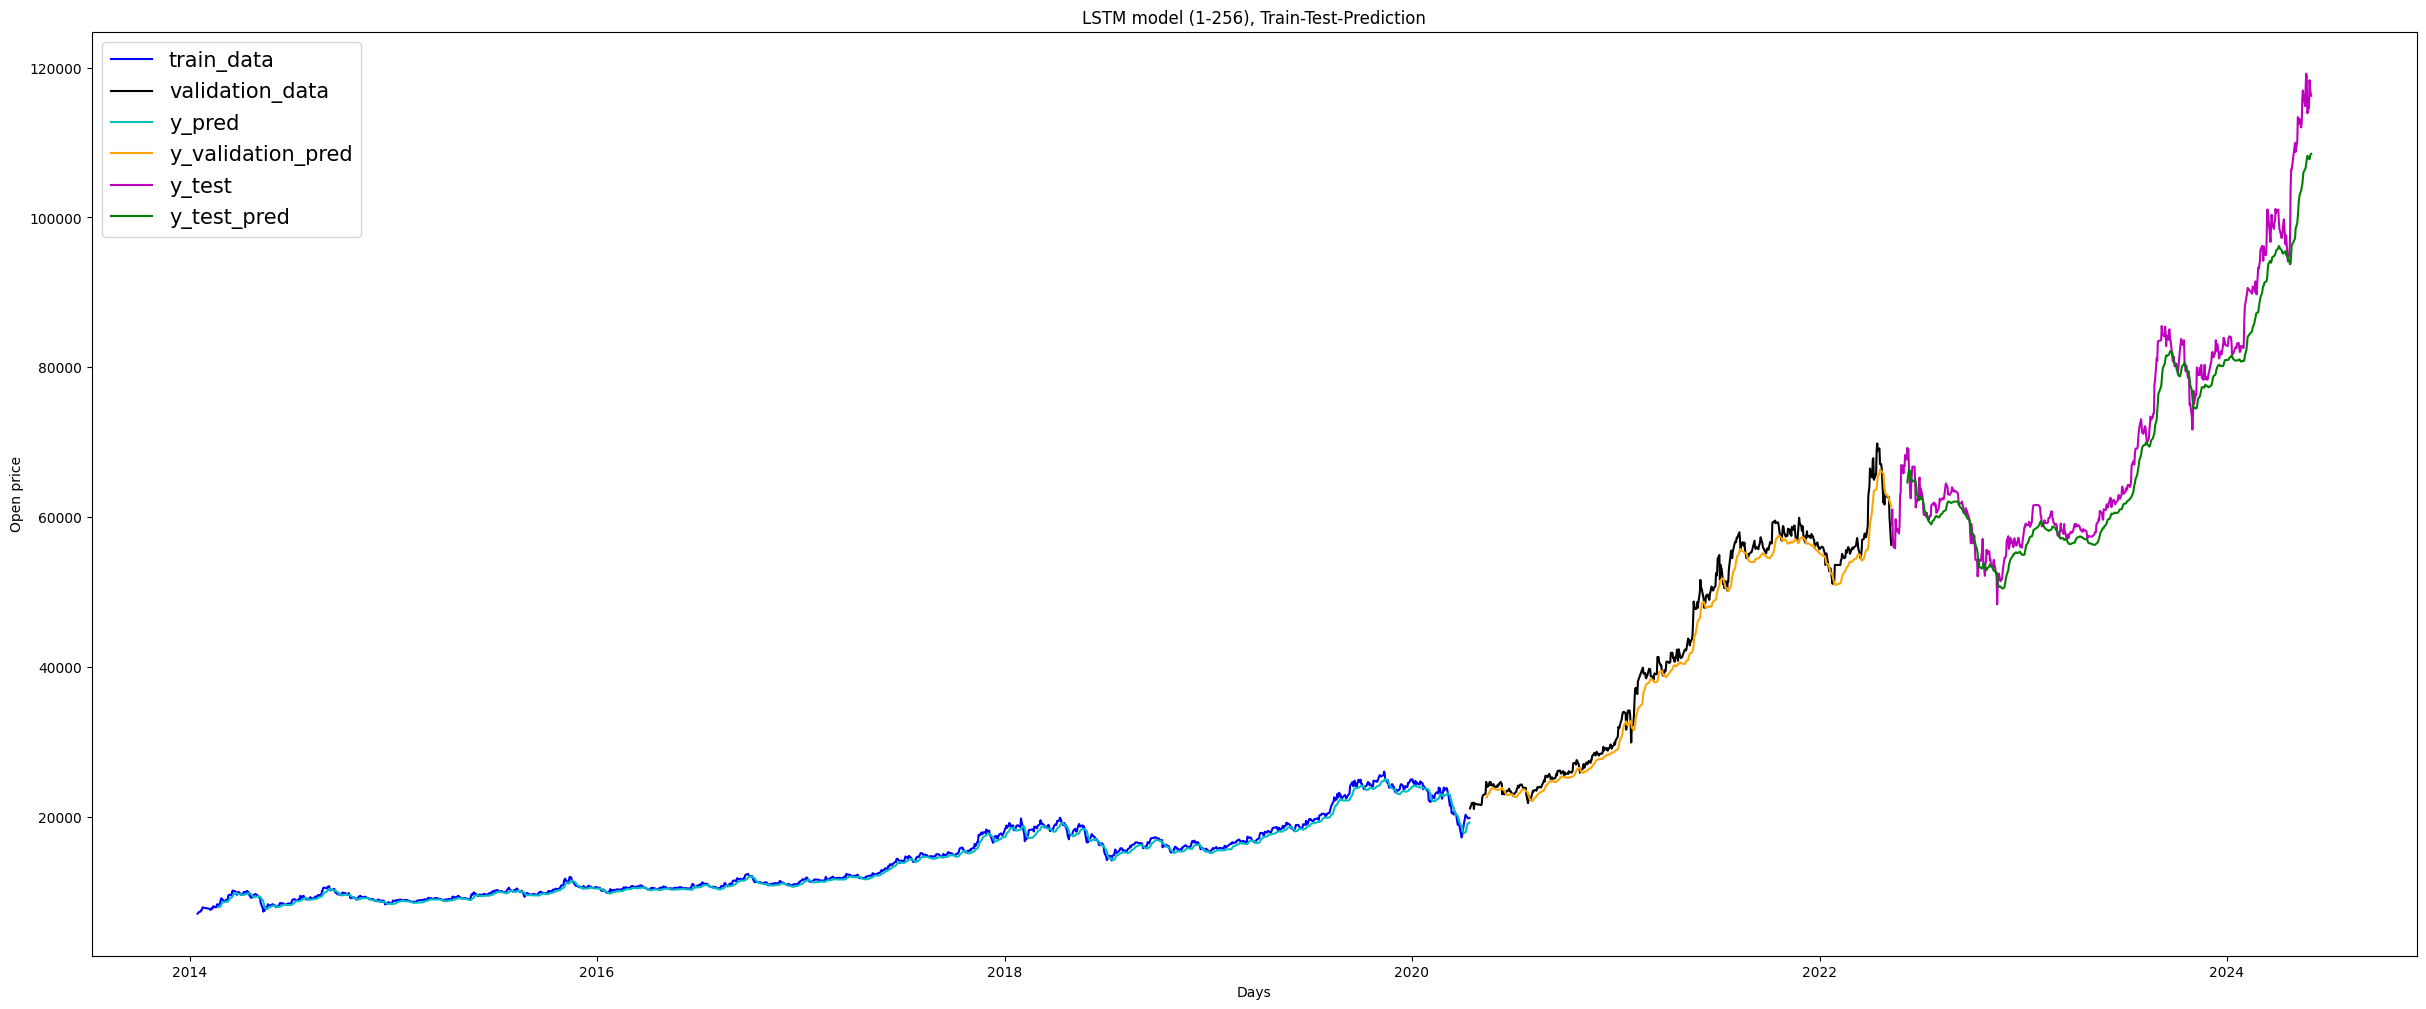

In [ ]:
# Visualisation
indicator = ticker
plt.subplots(figsize =(30,12))
plt.plot(train_data.index, train_data[indicator], label = "train_data", color = "b")
plt.plot(validation_data.index, validation_data[indicator], label = "validation_data", color = "k")
plt.plot(train_data.index[time_step:], y_train_pred[indicator], label = "y_pred", color = "c")
plt.plot(validation_data.index[time_step:], y_validation_pred[indicator], label = "y_validation_pred", color = "orange")
plt.plot(test_data.index, test_data[indicator], label = "y_test", color = "m")
plt.plot(test_data.index[time_step:], y_test_pred[indicator], label = "y_test_pred", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title(f"LSTM model ({hidden_layers}-{unit_num}), Train-Test-Prediction")
plt.legend(fontsize = 15)
plt.show()

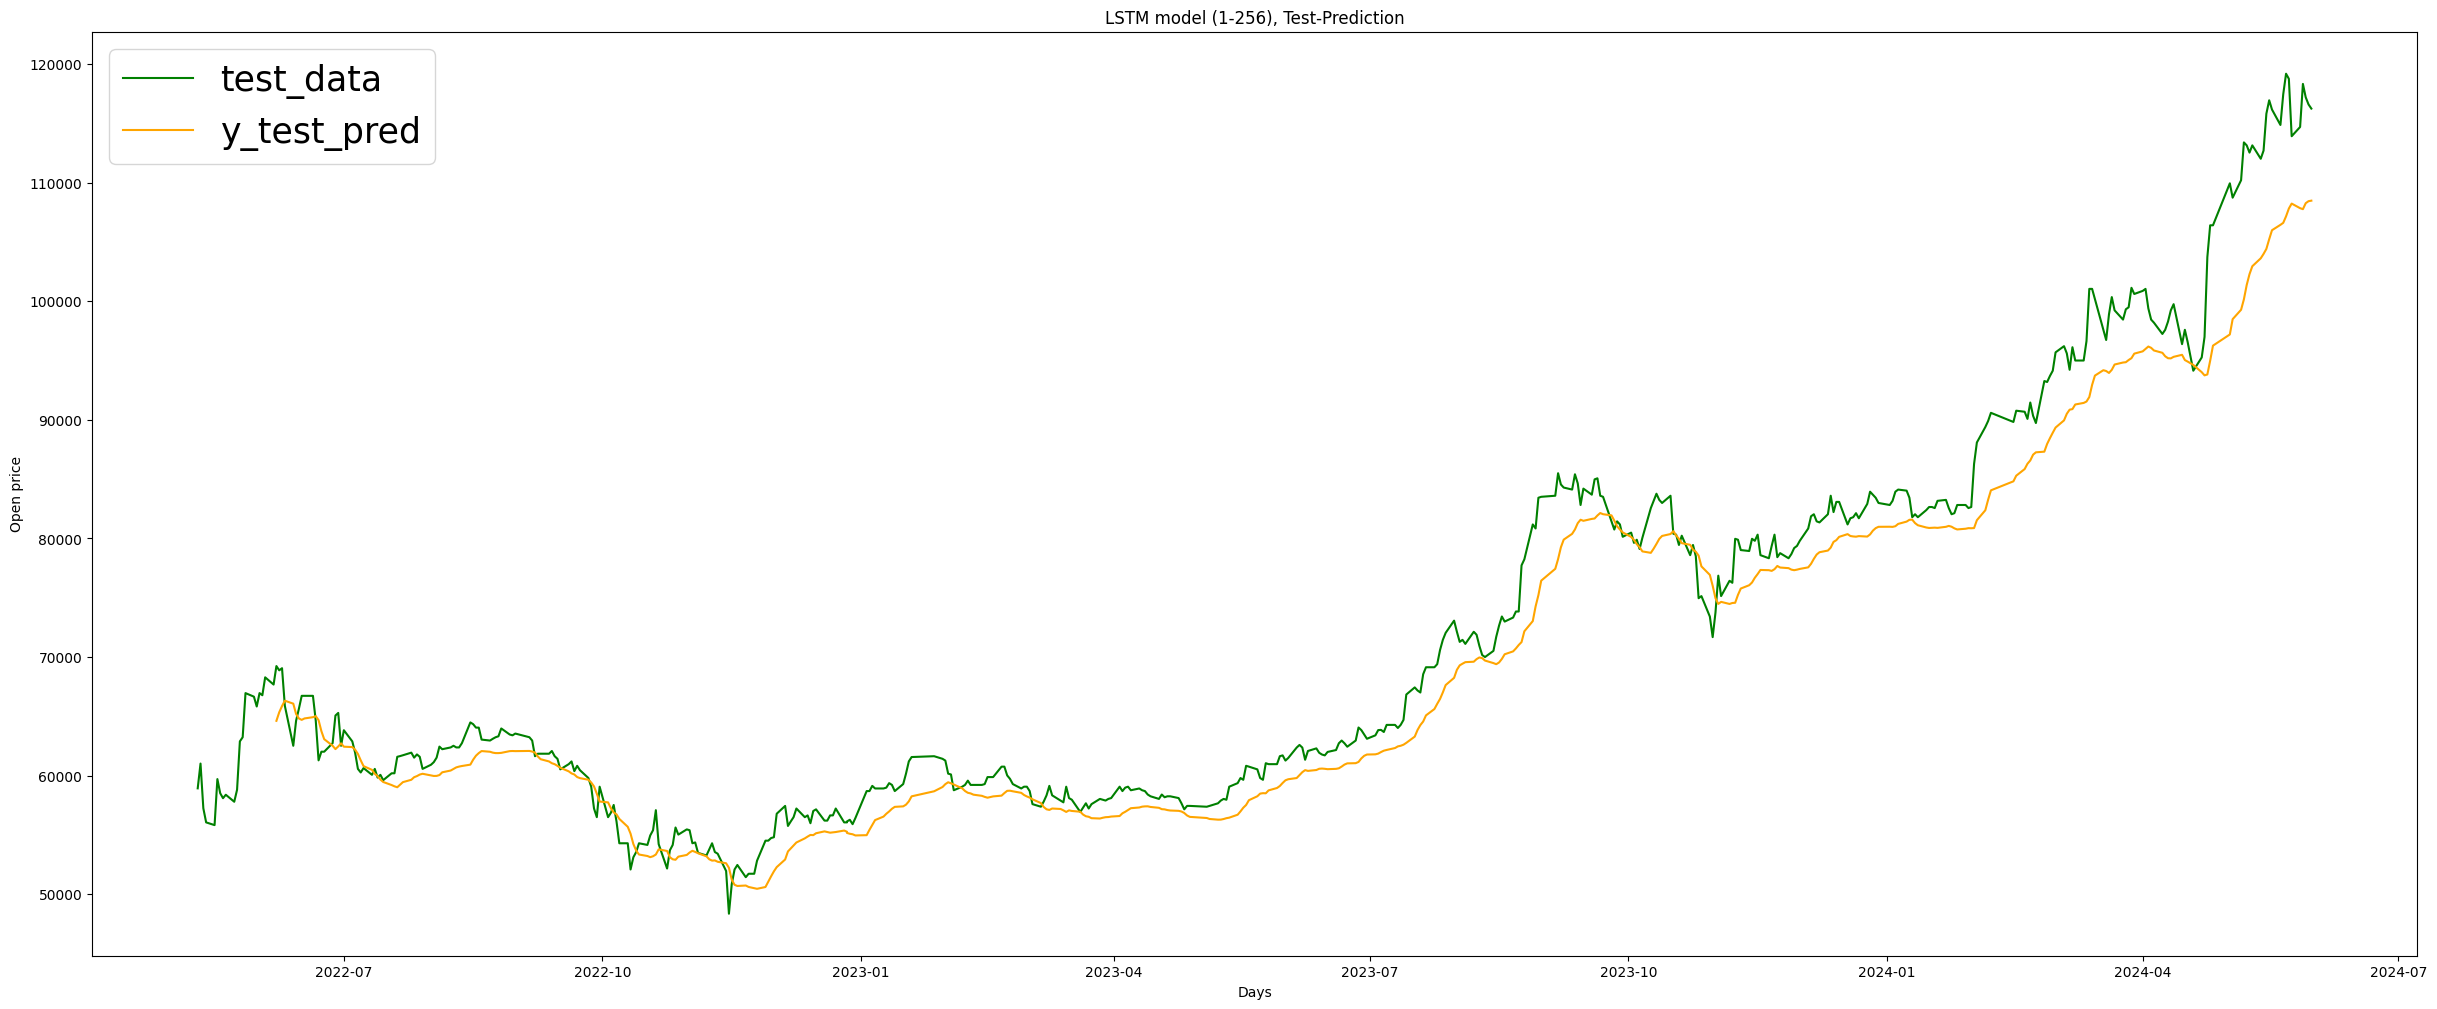

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(test_data.index, test_data[ticker], label = "test_data", color = "g")
plt.plot(test_data.index[time_step:], y_test_pred[indicator], label = "y_test_pred", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title(f"LSTM model ({hidden_layers}-{unit_num}), Test-Prediction")
plt.legend(fontsize = 25)
plt.show()